# **IMPORTS AND HELPER FUNCTIONS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.activations import sigmoid, relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LambdaCallback
import math

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.

    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.

    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    # References

      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 200, target_h =200):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 200, target_h = 200):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMG_DIR, 
        x_col="Source", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -K.mean(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon) + neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon)) 
        return loss
    return weighted_loss

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels,axis=0)/N
    negative_frequencies = np.ones_like(positive_frequencies) - positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [ ]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)


        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[ LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [ ]:
def find_lr(model_parm, data,epochs):
  X_batch, y_batch = next(data)
  X_idxs_resampled, _ = RandomUnderSampler().fit_resample(
      np.asarray(range(len(X_batch)))[:, np.newaxis], 
      y_batch)
  X_batch, y_batch = X_batch[X_idxs_resampled[:, 0]], y_batch[X_idxs_resampled[:, 0]]
  print(X_batch.shape)
  lr_finder = LRFinder(model_parm)
  lr_finder.find(X_batch, y_batch, start_lr=1e-20, end_lr=1e+5, batch_size=16, epochs=epochs)
  return lr_finder.plot_loss()

In [ ]:
def get_model_name(k):
    return 'model_{}.h5'.format(k)

# **DATA HANDLING**

In [ ]:
train_df = pd.read_excel('/content/drive/My Drive/Files-Covid/train.xlsx')
test_df = pd.read_excel('/content/drive/My Drive/Files-Covid/test.xlsx')
valid_df = pd.read_excel('/content/drive/My Drive/Files-Covid/valid.xlsx')
labels = ['Covid']

In [ ]:
IMG_DIR = "/content/drive/My Drive/Files-Covid/IMG_DIR/"
train_generator_96 = get_train_generator(train_df, IMG_DIR, "Source", labels,target_w = 96, target_h = 96)
valid_generator_96, test_generator_96= get_test_and_valid_generator(valid_df, test_df, train_df, IMG_DIR, "Source", labels, target_w = 96, target_h = 96)

train_generator_192 = get_train_generator(train_df, IMG_DIR, "Source", labels,target_w = 192, target_h = 192)
valid_generator_192, test_generator_192= get_test_and_valid_generator(valid_df, test_df, train_df, IMG_DIR, "Source", labels, target_w = 192, target_h = 192)

getting train generator...
Found 425 validated image filenames.
getting train and valid generators...
Found 425 validated image filenames.
Found 118 validated image filenames.
Found 203 validated image filenames.
getting train generator...
Found 425 validated image filenames.
getting train and valid generators...
Found 425 validated image filenames.
Found 118 validated image filenames.
Found 203 validated image filenames.


In [ ]:
freq_pos_96, freq_neg_96 = compute_class_freqs(train_generator_96.labels)
freq_pos_192, freq_neg_192 = compute_class_freqs(train_generator_192.labels)
print(freq_pos_96)
print(freq_neg_96)
print(freq_pos_192)
print(freq_neg_192)
pos_weights_96 = freq_neg_96
neg_weights_96 = freq_pos_96
pos_contribution = freq_pos_96 * pos_weights_96 
neg_contribution = freq_neg_96 * neg_weights_96

[0.44941176]
[0.55058824]
[0.44941176]
[0.55058824]


In [ ]:
main_df = [train_df,valid_df]
main_df = pd.concat(main_df)

# **MODEL AND TUNING**

In [ ]:
learn_96 = VGG16(include_top=False, weights = 'imagenet', input_tensor=Input(shape=(96, 96, 3)))
print(learn_96.summary())
model = Sequential()
model.add(learn_96)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(512,activation=relu,kernel_regularizer=l2(0.00001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1,activation=sigmoid))

for cnn_block_layer in learn_96.layers:
    cnn_block_layer.trainable = False

model.compile(optimizer=Adam(),
              loss=get_weighted_loss(pos_weights_96,neg_weights_96),
              metrics=['accuracy',AUC()])

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

In [ ]:
clr = CyclicLR(base_lr=1e-4, max_lr=1e-2,
                    step_size=1000., mode='triangular')

In [ ]:
img_indexes = list(main_df['Source'])
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)
valid_datagen = ImageDataGenerator(
    rescale=1. / 255
)

In [ ]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
kfold = KFold(n_splits=10, shuffle=True)
save_model = '/content/drive/My Drive/Files-Covid/'
fold_var = 1
for train_index,val_index in kfold.split(img_indexes):
  traindf = main_df.iloc[train_index, :].reset_index()
  validdf = main_df.iloc[val_index, :].reset_index()
  train_generator = train_datagen.flow_from_dataframe(dataframe=traindf,
                                                    directory=IMG_DIR,
                                                    x_col="Source",
                                                    y_col="Covid",
                                                    class_mode="raw",
                                                    target_size=(96, 96),
                                                    batch_size=16)

  valid_generator = valid_datagen.flow_from_dataframe(dataframe=validdf,
                                                    directory=IMG_DIR,
                                                    x_col="Source",
                                                    y_col="Covid",
                                                    class_mode="raw",
                                                    target_size=(96, 96),
                                                    batch_size=16)
  history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_df.index)/16, 
                              validation_steps=len(valid_df.index)/16, 
                              epochs = 20,
                              verbose=1,
                              callbacks = [EarlyStopping(monitor='val_loss',mode='min',patience=4,verbose=1,restore_best_weights = True),ModelCheckpoint(filepath='/content/drive/My Drive/Files-Covid/model_96_{}.h5'.format(fold_var), save_best_only=True, monitor='val_accuracy', mode='max'),clr])
  # model.load_weights('/content/drive/My Drive/Files-Covid/model_96_{}.h5'.format(fold_var))

  # results = model.evaluate_generator(valid_generator)
  # results = dict(zip(model.metrics_names,results))

  # VALIDATION_ACCURACY.append(results['accuracy'])
  # VALIDATION_LOSS.append(results['loss'])

  fold_var += 1

Found 488 validated image filenames.
Found 55 validated image filenames.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
27/26 [==============================] - 147s 5s/step - loss: 0.4622 - accuracy: 0.5579 - auc: 0.5587 - val_loss: 0.3333 - val_accuracy: 0.6182 - val_auc: 0.7812 - lr: 3.6730e-04
Epoch 2/20
27/26 [==============================] - 17s 616ms/step - loss: 0.3256 - accuracy: 0.6840 - auc: 0.7570 - val_loss: 0.3100 - val_accuracy: 0.6818 - val_auc: 0.7900 - lr: 6.3460e-04
Epoch 3/20
27/26 [==============================] - 5s 168ms/step - loss: 0.2641 - accuracy: 0.7547 - auc: 0.8376 - val_loss: 0.2948 - val_accuracy: 0.7273 - val_auc: 0.7838 - lr: 9.0190e-04
Epoch 4/20
27/26 [==============================] - 4s 152ms/step - loss: 0.2166 - accuracy: 0.8113 - auc: 0.8920 - val_loss: 0.2791 - val_accuracy: 0.7909 - val_auc: 0.8232 - lr: 0.0012
Epoch 5/20
27/26 [==============================] - 4s 141ms/step - loss: 0.2377 - accuracy

In [ ]:
learn_96.trainable = True
len(learn_96.layers)

19

In [ ]:
for layer in learn_96.layers[:13]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=Adam(),
              loss=get_weighted_loss(pos_weights_96,neg_weights_96),
              metrics=['accuracy',AUC()])

In [ ]:

kfold = KFold(n_splits=10, shuffle=True)
save_model = '/content/drive/My Drive/Files-Covid/'
fold_var = 1
for train_index,val_index in kfold.split(img_indexes):
  traindf = main_df.iloc[train_index, :].reset_index()
  validdf = main_df.iloc[val_index, :].reset_index()
  train_generator = train_datagen.flow_from_dataframe(dataframe=traindf,
                                                    directory=IMG_DIR,
                                                    x_col="Source",
                                                    y_col="Covid",
                                                    class_mode="raw",
                                                    target_size=(96, 96),
                                                    batch_size=16)

  valid_generator = valid_datagen.flow_from_dataframe(dataframe=validdf,
                                                    directory=IMG_DIR,
                                                    x_col="Source",
                                                    y_col="Covid",
                                                    class_mode="raw",
                                                    target_size=(96, 96),
                                                    batch_size=16)
  history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_df.index)/16, 
                              validation_steps=len(valid_df.index)/16, 
                              epochs = 20,
                              verbose=1,
                              callbacks = [EarlyStopping(monitor='val_loss',mode='min',patience=4,verbose=1,restore_best_weights = True),ModelCheckpoint(filepath='/content/drive/My Drive/Files-Covid/model_96_fine_tune_{}.h5'.format(fold_var), save_best_only=True, monitor='val_accuracy', mode='max'),clr])
  # model.load_weights('/content/drive/My Drive/Files-Covid/model_96_{}.h5'.format(fold_var))

  # results = model.evaluate_generator(valid_generator)
  # results = dict(zip(model.metrics_names,results))

  # VALIDATION_ACCURACY.append(results['accuracy'])
  # VALIDATION_LOSS.append(results['loss'])

  fold_var += 1

Found 488 validated image filenames.
Found 55 validated image filenames.
Epoch 1/20
27/26 [==============================] - 5s 194ms/step - loss: 0.4493 - accuracy: 0.6667 - auc_1: 0.7102 - val_loss: 1.0395 - val_accuracy: 0.5818 - val_auc_1: 0.6386 - lr: 0.0017
Epoch 2/20
27/26 [==============================] - 4s 159ms/step - loss: 0.4594 - accuracy: 0.6297 - auc_1: 0.6713 - val_loss: 3.7844 - val_accuracy: 0.4727 - val_auc_1: 0.5000 - lr: 0.0020
Epoch 3/20
27/26 [==============================] - 5s 177ms/step - loss: 0.3899 - accuracy: 0.6840 - auc_1: 0.7511 - val_loss: 3.6781 - val_accuracy: 0.4909 - val_auc_1: 0.5000 - lr: 0.0022
Epoch 4/20
27/26 [==============================] - 6s 215ms/step - loss: 0.3309 - accuracy: 0.7382 - auc_1: 0.8117 - val_loss: 0.8964 - val_accuracy: 0.6364 - val_auc_1: 0.7315 - lr: 0.0025
Epoch 5/20
27/26 [==============================] - 4s 159ms/step - loss: 0.3131 - accuracy: 0.7665 - auc_1: 0.8291 - val_loss: 1.5641 - val_accuracy: 0.4909 - val

In [ ]:
# history = model.fit_generator(train_generator_96, 
#                               validation_data=valid_generator_96,
#                               steps_per_epoch=25, 
#                               validation_steps=12, 
#                               epochs = 50,
#                               verbose=1,
#                               callbacks = [EarlyStopping(monitor='val_loss',mode='min',patience=10,verbose=1,restore_best_weights = True),ModelCheckpoint(filepath='/content/drive/My Drive/Files-Covid/model_96_test1.h5', save_best_only=True, monitor='val_accuracy', mode='max'),clr])

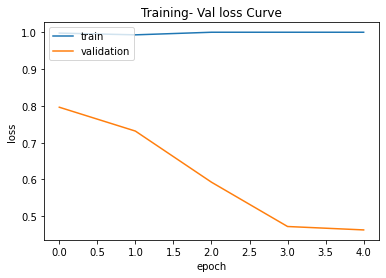

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training- Val loss Curve")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# model1 = load_model('/content/drive/My Drive/Files-Covid/model_96_1.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})
# model2 = load_model('/content/drive/My Drive/Files-Covid/model_96_2.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})
# model3 = load_model('/content/drive/My Drive/Files-Covid/model_96_3.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})
# model4 = load_model('/content/drive/My Drive/Files-Covid/model_96_4.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})
# model5 = load_model('/content/drive/My Drive/Files-Covid/model_96_5.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})
# model6 = load_model('/content/drive/My Drive/Files-Covid/model_96_6.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})
# model7 = load_model('/content/drive/My Drive/Files-Covid/model_96_7.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})
# model8 = load_model('/content/drive/My Drive/Files-Covid/model_96_8.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})
# model9 = load_model('/content/drive/My Drive/Files-Covid/model_96_9.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})
# model10 = load_model('/content/drive/My Drive/Files-Covid/model_96_10.h5',custom_objects={'weighted_loss':get_weighted_loss(pos_weights_96,neg_weights_96)})

In [ ]:
# model1

In [ ]:
predicted_vals1 = model.predict_generator(test_generator_96, steps = len(test_generator_96))
# predicted_vals2 = model2.predict_generator(test_generator_96, steps = len(test_generator_96))
# predicted_vals3 = model3.predict_generator(test_generator_96, steps = len(test_generator_96))
# predicted_vals4 = model4.predict_generator(test_generator_96, steps = len(test_generator_96))
# predicted_vals5 = model5.predict_generator(test_generator_96, steps = len(test_generator_96))
# predicted_vals6 = model6.predict_generator(test_generator_96, steps = len(test_generator_96))
# predicted_vals7 = model7.predict_generator(test_generator_96, steps = len(test_generator_96))
# predicted_vals8 = model8.predict_generator(test_generator_96, steps = len(test_generator_96))
# predicted_vals9 = model9.predict_generator(test_generator_96, steps = len(test_generator_96))
# predicted_vals10 = model10.predict_generator(test_generator_96, steps = len(test_generator_96))

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

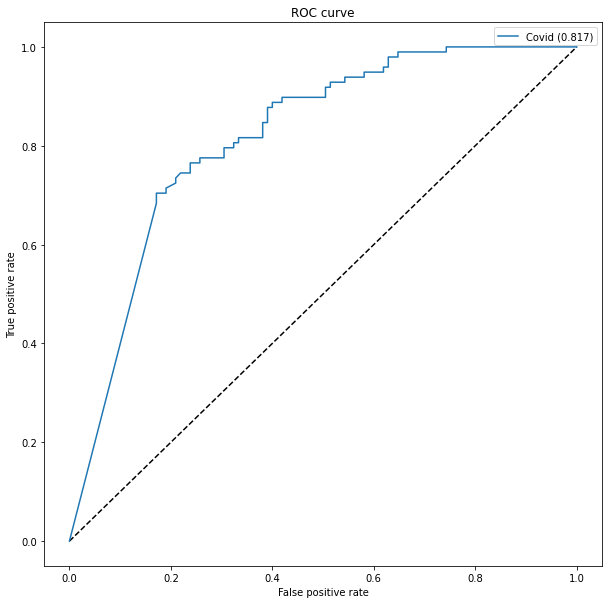

In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals1, test_generator_96)

In [ ]:
len(test_df.index)/16

12.6875

In [ ]:
model.evaluate(test_generator_96,batch_size=16, verbose=1, steps=12)

12/12 [==============================] - 1s 61ms/step - loss: 0.6480 - accuracy: 0.8646 - auc_1: 0.7713


[0.6480233073234558, 0.8645833134651184, 0.7712963223457336]

In [ ]:
export_dir = '/content/drive/My Drive/Files-Covid/saved_model/1'

tf.saved_model.save(model,export_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Files-Covid/saved_model/1/assets


In [ ]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
import pathlib
tflite_model_file = pathlib.Path('/content/drive/My Drive/Files-Covid/init_model.tflite')
tflite_model_file.write_bytes(tflite_model)

15011080

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]